<a href="https://colab.research.google.com/github/Nathan-Bush46/AIPI-Interpretable-ML/blob/main/assignments/Explainable%20Techniques%20II.ipynb" target="_blank">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# Nathan Bush



Notes: Used [this link](https://archive.ics.uci.edu/dataset/9/auto+mpg) to get data code to pull it. No AI yet

In [ ]:
# !pip install ucimlrepo
# uncomment to get lib it you want

In [1]:
from ucimlrepo import fetch_ucirepo
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# fetch dataset
auto_mpg = fetch_ucirepo(id=9)

# data (as pandas dataframes)
X = auto_mpg.data.features
y = auto_mpg.data.targets

# metadata
auto_mpg.metadata

{'uci_id': 9,
 'name': 'Auto MPG',
 'repository_url': 'https://archive.ics.uci.edu/dataset/9/auto+mpg',
 'data_url': 'https://archive.ics.uci.edu/static/public/9/data.csv',
 'abstract': 'Revised from CMU StatLib library, data concerns city-cycle fuel consumption',
 'area': 'Other',
 'tasks': ['Regression'],
 'characteristics': ['Multivariate'],
 'num_instances': 398,
 'num_features': 7,
 'feature_types': ['Real', 'Categorical', 'Integer'],
 'demographics': [],
 'target_col': ['mpg'],
 'index_col': ['car_name'],
 'has_missing_values': 'yes',
 'missing_values_symbol': 'NaN',
 'year_of_dataset_creation': 1993,
 'last_updated': 'Thu Aug 10 2023',
 'dataset_doi': '10.24432/C5859H',
 'creators': ['R. Quinlan'],
 'intro_paper': None,
 'additional_info': {'summary': 'This dataset is a slightly modified version of the dataset provided in the StatLib library.  In line with the use by Ross Quinlan (1993) in predicting the attribute "mpg", 8 of the original instances were removed because they had 

In [3]:
# variable information
auto_mpg.variables

,name,role,type,demographic,description,units,missing_values
0,displacement,Feature,Continuous,None,None,None,no
1,mpg,Target,Continuous,None,None,None,no
2,cylinders,Feature,Integer,None,None,None,no
3,horsepower,Feature,Continuous,None,None,None,yes
4,weight,Feature,Continuous,None,None,None,no
5,acceleration,Feature,Continuous,None,None,None,no
6,model_year,Feature,Integer,None,None,None,no
7,origin,Feature,Integer,None,None,None,no
8,car_name,ID,Categorical,None,None,None,no


note Used some chatGPT here as showen

In [4]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1
)

# used AI to set model then just set it to use really shallow trees for speed and given that it seems to work well
# XGBoost regressor
model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=2,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=1
)
model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


used chatgpt to test model to make sure it is decent

In [5]:

# Predictions
y_pred = model.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.2f}")
print(f"R²:  {r2:.3f}")

MSE: 6.90
R²:  0.882


It is fine.
- Only off by ~ 2.5 mpg on avearge  
- The model explains about 88% of the variance in fuel efficiency.
 

# Exploratory analysis

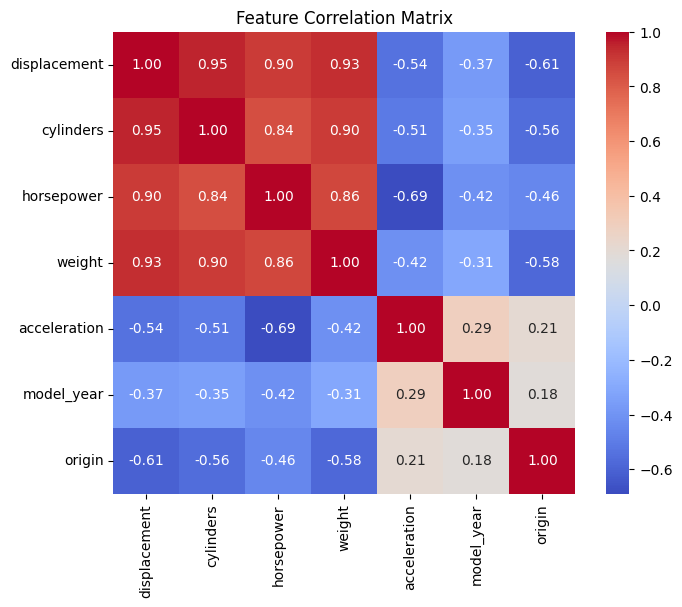

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation matrix
corr = X.corr()

# Show as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Feature Correlation Matrix")
plt.show()

- Horsepower, displacement, and cylinders are all strongly positive correlatated. As such the effects of one on its own will be hard see...
- Acceleration time decreases as horsepower increases (negative correlation), meaning stronger engines reach 60 mph faster. 

Note: acceleration is measured as time to 60 mph. In other words a lower value means quicker acceleration.

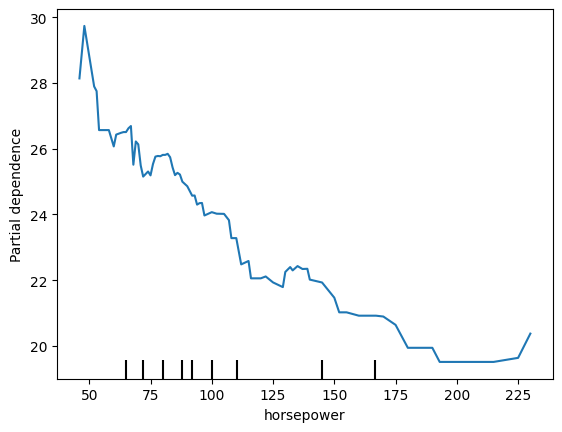

In [7]:
# Used chatgpt to graph but I made it as simple as I can
PartialDependenceDisplay.from_estimator(model, X_train, ["horsepower"])

# Interpretation PDP

- In general this graph shows cars with lower horsepower have better fuel efficiency (higher miles per gallon) and cars with more horsepower have worse fuel efficiency.  

### Caveats:
- This assumes horsepower varies independently, but in reality it’s correlated with weight/cylinders.  
- The plot is most reliable where the data is dense (around 70–115 horsepower).  

AI used only for spell checking


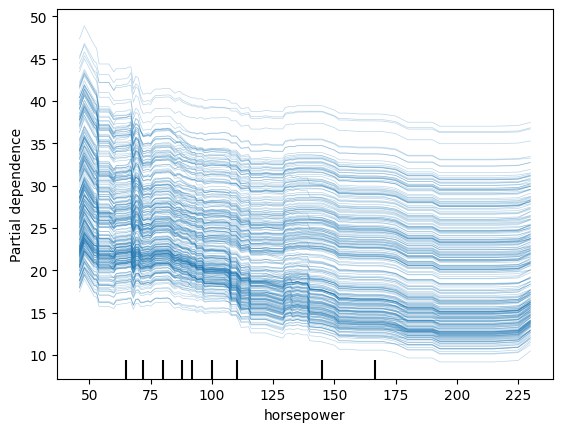

In [8]:
PartialDependenceDisplay.from_estimator(
    model, X_train, ["horsepower"], kind="individual")

# Interpretation ICE

- This shows the same downward trend as PDP: more horsepower consistently means lower MPG.
- The lines look nearly parallel, so the effect of horsepower seems mostly stable across cars without big interactions.

**Caveats:**

* It still assumes horsepower can vary independently of weight/cylinders, which you know it doesn't.
* Reliability is still the highest where the data is dense (around 70–115 horsepower).


AI only for spell checking

Note used chatgpt to help write ale code but it was wrong so I fixed

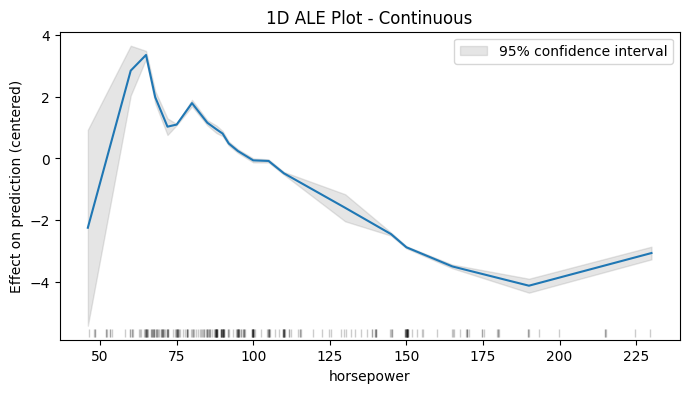

In [ ]:
from PyALE import ale

# 1D ALE plot for horsepower
ale_eff = ale(
    X=X_train,
    model=model,
    feature_type="continuous",
    feature=["horsepower"],
    grid_size=20,      # how many bins
    include_CI=True,   # optional: show confidence intervals
    C=0.95             # confidence level
)

# Interpretation ALE

- The overall trend still matches the graphs from before: low horsepower cars get better MPG, and higher horsepower cars lose efficiency.

### Caveats:

- Some ranges (like very high and very low horsepower) still have fewer data points, so the effect there is less certain. Even though cars in these ranges don’t fully follow the trend, this may be due to other factors given the limited data.

- Even though ALE handles correlations better, horsepower is still linked to weight, cylinders, and displacement, so its effect can’t be separated completely from those features.

### Note:
ALE shows the downward trend and the upward bump in efficiency at higher horsepower more clearly than PDP because it considers local changes where 'real cars' exist, while PDP averages over unrealistic combinations that blur the effect.